In [7]:
!pip install awscli


  Using cached awscli-1.42.24-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 50.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 73.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 28.3 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
  Attempting uninstall: botocore
    Found existing installation: botocore 1.39.1
    Uninstalling botocore-1.39.1:
      Successfully uninstalled botocore-1.39.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud

In [6]:
!rm -rf /kaggle/working/*


In [8]:
!aws s3 cp --no-sign-request --region ca-central-1 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/" ./CIC-CSV --recursive


download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv to CIC-CSV/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv to CIC-CSV/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv to CIC-CSV/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv to CIC-CSV/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv to CIC-CSV/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Wednesday-14-02-2018_Traf

In [10]:
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

folder = "/kaggle/working/CIC-CSV"
files = sorted(os.listdir(folder))
output_dir = "merged_cic2018_dataset"

chunksize = 100_000

# remove old dataset folder if exists
if os.path.exists(output_dir):
    import shutil
    shutil.rmtree(output_dir)

for file in files:
    file_path = os.path.join(folder, file)
    print(f"Processing {file_path} ...")

    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        # convert numeric-like cols safely
        for col in chunk.columns:
            if pd.api.types.is_numeric_dtype(chunk[col]):
                chunk[col] = chunk[col].astype(float)
            else:
                converted = pd.to_numeric(chunk[col], errors="coerce")
                if converted.notna().mean() > 0.95:
                    chunk[col] = converted.astype(float)

        # convert pandas chunk arrow table
        table = pa.Table.from_pandas(chunk, preserve_index=False)
        pq.write_to_dataset(
            table,
            root_path=output_dir,
            compression="snappy"
        )

        del chunk


Processing /kaggle/working/CIC-CSV/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv ...
Processing /kaggle/working/CIC-CSV/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv ...
Processing /kaggle/working/CIC-CSV/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv ...
Processing /kaggle/working/CIC-CSV/Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv ...
Processing /kaggle/working/CIC-CSV/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv ...
Processing /kaggle/working/CIC-CSV/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv ...
Processing /kaggle/working/CIC-CSV/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv ...
Processing /kaggle/working/CIC-CSV/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv ...
Processing /kaggle/working/CIC-CSV/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv ...
Processing /kaggle/working/CIC-CSV/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv ...


In [ ]:
df=pd.read

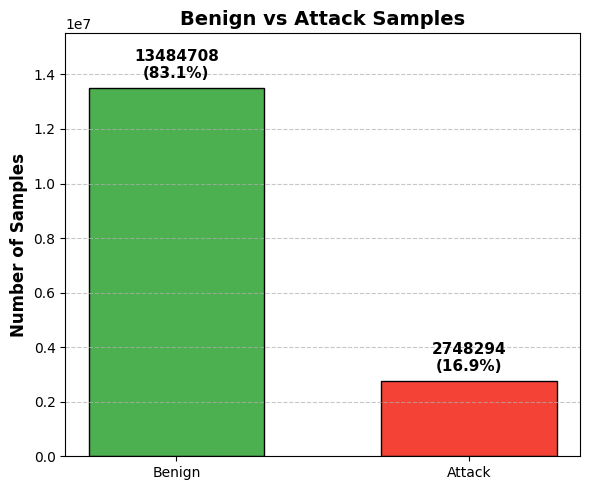

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
import dask.dataframe as dd
df = dd.read_parquet("/kaggle/working/merged_cic2018_dataset", engine="pyarrow")


# Split by label
df_benign = df[df['Label'] == 'Benign'].copy()
df_not_benign = df[df['Label'] != 'Benign'].copy()

# Prepare counts
labels = ["Benign", "Attack"]
counts = [len(df_benign), len(df_not_benign)]
total = sum(counts)

# Plot
plt.figure(figsize=(6,5))
bars = plt.bar(labels, counts, color=["#4CAF50", "#F44336"], width=0.6, edgecolor="black")

plt.ylabel("Number of Samples", fontsize=12, fontweight="bold")
plt.title("Benign vs Attack Samples", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Increase y-limit for better spacing above bars
plt.ylim(0, max(counts) * 1.15)

# Annotate bars with numbers + percentages
for bar, count in zip(bars, counts):
    percent = f"{(count/total)*100:.1f}%"
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + (max(counts) * 0.02),  # padding above bar
        f"{count}\n({percent})",
        ha="center", va="bottom", fontsize=11, fontweight="bold"
    )

plt.tight_layout()
plt.savefig("benign_vs_attack.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
df.to_parquet("merged_clean.parquet", write_index=False)


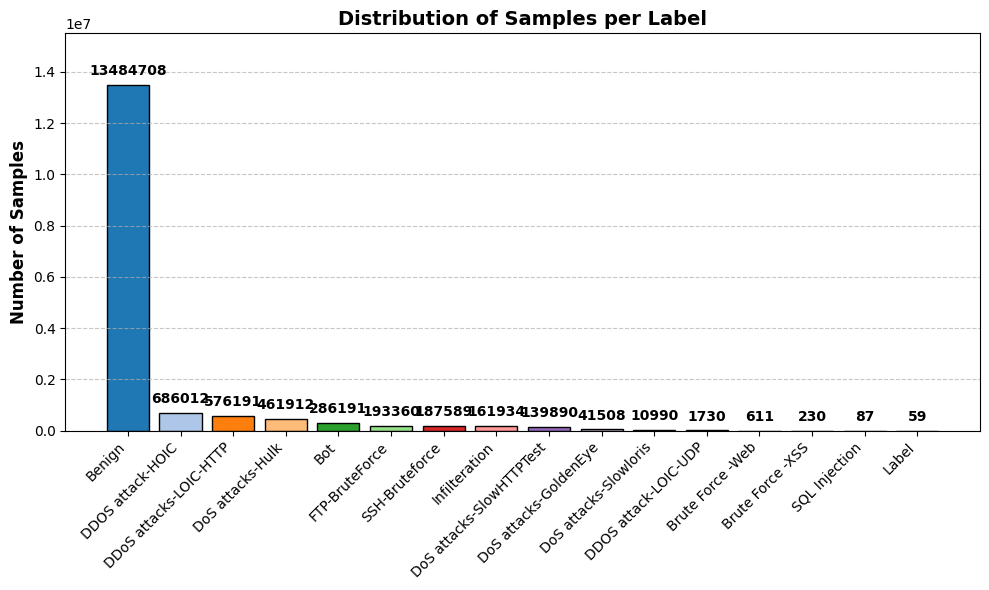

In [4]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

# Load data lazily
df = dd.read_parquet("/kaggle/working/merged_cic2018_dataset", engine="pyarrow")

# Compute value counts and convert to Pandas
counts = df['Label'].value_counts().compute().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(counts.index, counts.values, color=plt.cm.tab20.colors, edgecolor="black")

plt.ylabel("Number of Samples", fontsize=12, fontweight="bold")
plt.title("Distribution of Samples per Label", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Increase y-limit for padding
plt.ylim(0, max(counts.values) * 1.15)

# Annotate bars
for bar, count in zip(bars, counts.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + (max(counts.values) * 0.02),
        str(count),
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.tight_layout()
plt.savefig("label_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


In [10]:
import dask.dataframe as dd

# Load all parquet files (schema may vary between partitions)
df = dd.read_parquet("/kaggle/working/merged_cic2018_dataset", engine="pyarrow")

# Make sure only keep numeric + Label (drop inconsistent columns)
keep_cols = [c for c in df.columns if c not in ["Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol"]]

df_clean = df[keep_cols]

# Save back as a single clean parquet
df_clean.to_parquet(
    "/kaggle/working/merged_cic2018_clean.parquet",
    engine="pyarrow",
    write_index=False
)


KeyboardInterrupt: 

In [11]:
import dask.dataframe as dd
import os

# Load dataset lazily
df = dd.read_parquet("/kaggle/working/merged_cic2018_clean.parquet", engine="pyarrow")

# Keep only attacks
df_attack = df[df['Label'] != 'Benign']

# Create output folder
output_dir = "attacks"
os.makedirs(output_dir, exist_ok=True)

# Get unique attack types (compute small array in memory)
attack_types = df_attack['Label'].unique().compute()

# Save each attack type separately
for attack_type in attack_types:
    safe_name = str(attack_type).replace(" ", "_").replace("/", "_")  # avoid bad filename chars
    file_path = os.path.join(output_dir, f"{safe_name}.csv")

    df_filtered = df_attack[df_attack['Label'] == attack_type]
    df_filtered.to_csv(file_path, index=False, single_file=True)  # single_file=True is key!

    print(f"Saved {attack_type} -> {file_path}")

print("✅ All attacks saved separately!")


Saved DDoS attacks-LOIC-HTTP -> attacks/DDoS_attacks-LOIC-HTTP.csv
Saved SQL Injection -> attacks/SQL_Injection.csv
Saved DoS attacks-Slowloris -> attacks/DoS_attacks-Slowloris.csv
Saved SSH-Bruteforce -> attacks/SSH-Bruteforce.csv
Saved DDOS attack-HOIC -> attacks/DDOS_attack-HOIC.csv
Saved DoS attacks-GoldenEye -> attacks/DoS_attacks-GoldenEye.csv
Saved FTP-BruteForce -> attacks/FTP-BruteForce.csv
Saved Infilteration -> attacks/Infilteration.csv
Saved DoS attacks-Hulk -> attacks/DoS_attacks-Hulk.csv
Saved Bot -> attacks/Bot.csv
Saved DDOS attack-LOIC-UDP -> attacks/DDOS_attack-LOIC-UDP.csv
Saved Brute Force -Web -> attacks/Brute_Force_-Web.csv
Saved DoS attacks-SlowHTTPTest -> attacks/DoS_attacks-SlowHTTPTest.csv
Saved Label -> attacks/Label.csv
Saved Brute Force -XSS -> attacks/Brute_Force_-XSS.csv
✅ All attacks saved separately!
